In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## TFIDF features

In [2]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]

In [3]:
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [4]:
X.shape

(404290, 29)

In [5]:
X = X.sample(100001)
X.shape

(100001, 29)

In [6]:
duplicate = X.is_duplicate

In [7]:
#removing id from X
X=X.drop(['id','is_duplicate'],axis=1)
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [8]:
y=np.array(duplicate)

In [9]:
#splitting data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 27)
(70000,)
(30001, 27)
(30001,)


In [12]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)

In [13]:
#tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
X_train_tfidf=tf_idf_vect.fit_transform(X_train_ques)
X_test_tfidf=tf_idf_vect.transform(X_test_ques)

In [14]:
#adding tfidf features to our train and test data using hstack
X_train = hstack((X_train.values,X_train_tfidf))
X_test= hstack((X_test.values,X_test_tfidf))
print(X_train.shape)
print(X_test.shape)

(70000, 29486)
(30001, 29486)


## Logistic Regression with hyperparameter tuning

In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

For values of alpha =  1e-05 The log loss is: 0.4209677210204028
For values of alpha =  0.0001 The log loss is: 0.4270374714362368
For values of alpha =  0.001 The log loss is: 0.41795212046629887
For values of alpha =  0.01 The log loss is: 0.44425047757095737
For values of alpha =  0.1 The log loss is: 0.45993394710976865
For values of alpha =  1 The log loss is: 0.49320651377593105
For values of alpha =  10 The log loss is: 0.5439230173703492
For values of alpha =  100 The log loss is: 0.5854992544713036


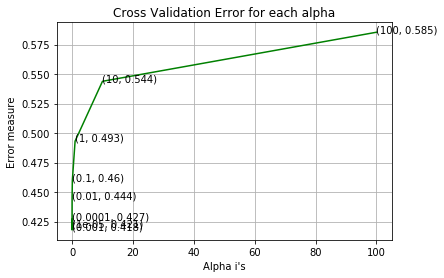

For values of best alpha =  0.001 The train log loss is: 0.4201857983964847
For values of best alpha =  0.001 The test log loss is: 0.41795212046629887
Total number of data points : 30001


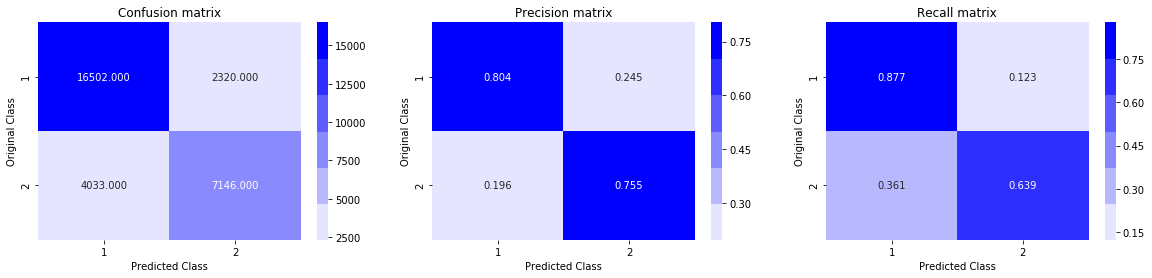

In [15]:
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4295790937500061
For values of alpha =  0.0001 The log loss is: 0.4491064905281502
For values of alpha =  0.001 The log loss is: 0.4697426059688926
For values of alpha =  0.01 The log loss is: 0.46249344997413255
For values of alpha =  0.1 The log loss is: 0.4722827825627129
For values of alpha =  1 The log loss is: 0.5815991024021562
For values of alpha =  10 The log loss is: 0.6557719199909435
For values of alpha =  100 The log loss is: 0.6603816797913504
For values of alpha =  1000 The log loss is: 0.6603816797913504


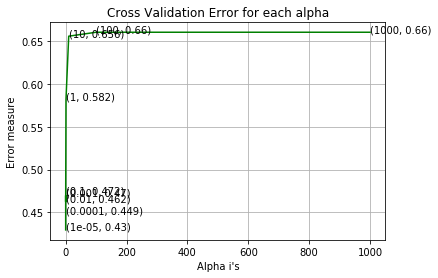

For values of best alpha =  1e-05 The train log loss is: 0.42881359528504814
For values of best alpha =  1e-05 The test log loss is: 0.4295790937500061
Total number of data points : 30001


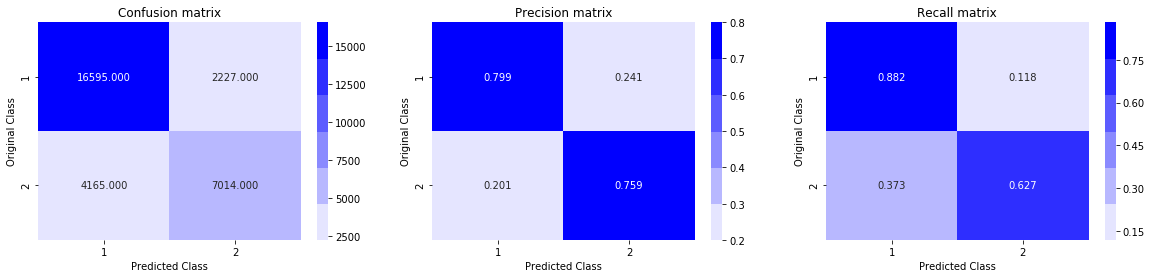

In [16]:
alpha = [10 ** x for x in range(-5, 4)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## XGBOOST

In [15]:
import xgboost as xgb

In [18]:
n_estimators = [50,100,150,200,300,400,500]
test_scores = []
train_scores = []
for i in n_estimators:
    clf = xgb.XGBClassifier(learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, y_pred, eps=1e-15)
    train_scores.append(log_loss_train)
    y_pred = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, y_pred, eps=1e-15)
    test_scores.append(log_loss_test)
    print('For n_estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)

For n_estimators =  50 Train Log Loss  0.3785471239292063 Test Log Loss  0.378644648759011
For n_estimators =  100 Train Log Loss  0.35721891773104686 Test Log Loss  0.3588643326741902
For n_estimators =  150 Train Log Loss  0.34596415403819514 Test Log Loss  0.3500678128824883
For n_estimators =  200 Train Log Loss  0.33879283321900605 Test Log Loss  0.34508519503323937
For n_estimators =  300 Train Log Loss  0.3276304254709857 Test Log Loss  0.33826555355283994
For n_estimators =  400 Train Log Loss  0.31938879944436255 Test Log Loss  0.3336640659977005
For n_estimators =  500 Train Log Loss  0.3121442960014718 Test Log Loss  0.3301124005839332


The test log loss is: 0.3301124005839332


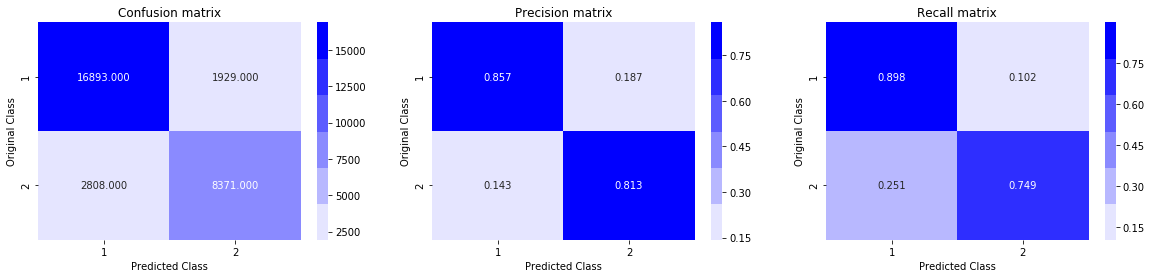

In [19]:
clf=xgb.XGBClassifier(learning_rate=0.1,n_estimators=500,n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, y_pred, eps=1e-15))
predicted_y =np.argmax(y_pred,axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Hyperparameter tunning using RandomSearch

In [16]:
%time
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"max_depth":[1,5,10,50,100,500,1000],
              "n_estimators":[50,100,150,200,300,400,500]}

model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=10,scoring='neg_log_loss',cv=3,n_jobs=-1)

model.fit(X_train,y_train)
model.best_params_

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


{'n_estimators': 300, 'max_depth': 10}

Train log loss =  0.21204601189497468  Test log loss =  0.31668203330180406


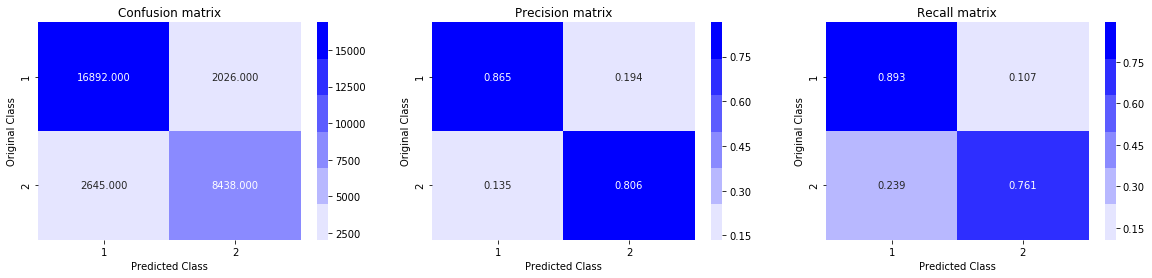

In [19]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=10,n_estimators=300)
clf.fit(X_train,y_train)
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

## Procedure and Observation

- 1) First we did Exploratory Data Analysis on Quora Question Pair data in which we performed such as finding number of different questions, checking for duplicates, number of occurence of questions etc.  
- 2) Then we performed some feature extraction like fuzz ratio, fuzz partial ration, longest common substring etc.
- 3) After performing feature extraction we applied some visualisation techniques such as pair-plot, violin plot, TSNE etc.
- 4) Then we peformed tfidf-w2vec vectorizer on pair of questions dataset and then we merged each tfidf-w2vec vectors to our advanced featured vectors. 
- 5) In the next step we applied some machine learning algorithm such as logistic regression, support vector machines etc and found log-loss for both train and test dataset. 
- 6) After choosing best parameters we then plotted confusion matrix, precision matrix and recall matrix for each one. 
- 7) we did same process for tfidf vectorizer at the end of this project.

In [21]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","log loss"]
x.add_row(['Logistic regression','TFIDF w2vec','0.4487'])
x.add_row(['Linear SVM','TFIDF w2vec','0.4835'])
x.add_row(['XGBOOST','TFIDF w2vec','0.3590'])
x.add_row(['Logistic regression','TFIDF ','0.4201'])
x.add_row(['Linear SVM','TFIDF','0.4288'])
x.add_row(['XGBOOST','TFIDF ','0.3121'])

print(x)

+---------------------+-------------+----------+
|        Model        |  vectorizer | log loss |
+---------------------+-------------+----------+
| Logistic regression | TFIDF w2vec |  0.4487  |
|      Linear SVM     | TFIDF w2vec |  0.4835  |
|       XGBOOST       | TFIDF w2vec |  0.3590  |
| Logistic regression |    TFIDF    |  0.4201  |
|      Linear SVM     |    TFIDF    |  0.4288  |
|       XGBOOST       |    TFIDF    |  0.3121  |
+---------------------+-------------+----------+


- It is observed here that XGBOOST is giving the best result  